In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import tensorflow as tf
from scipy import misc
import matplotlib.patches as patches

In [0]:
filelist = glob.glob("drive/My Drive/negative1/*.*")

In [4]:
len(filelist)

2000

In [5]:
train_data = np.array([misc.imread(fname) for fname in filelist])
train_data.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


(2000, 227, 227, 3)

In [6]:
t = train_data/train_data.max()
t.shape

(2000, 227, 227, 3)

In [7]:
val = t[1600:]
val.shape

(400, 227, 227, 3)

In [8]:
t = t[:1600]
t.shape

(1600, 227, 227, 3)

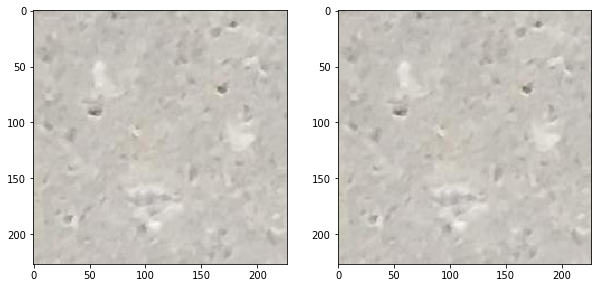

In [9]:
fig, ax = plt.subplots(1, 2,figsize=(10,10))
ax[0].imshow(train_data[0])
ax[1].imshow(t[0])
plt.show()

In [0]:
tf.reset_default_graph()

In [0]:
x = tf.placeholder(tf.float32, [None, 227, 227, 3], name='input_data')
y = tf.placeholder(tf.float32, [None, 227, 227, 3], name='target_data')

### 3.0

In [0]:
epochs = 5
batch_size=20
l2_reg = 0.0001
#encoding-----
l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)

enc_conv0 = tf.layers.conv2d(x, 64, 3, activation=tf.nn.elu, kernel_regularizer=l2_regularizer) #223
enc_conv0 = tf.layers.conv2d(enc_conv0, 64, 3, activation=tf.nn.elu, kernel_regularizer=l2_regularizer) #223
#enc_max = tf.layers.max_pooling2d(enc_conv0, 3, 2) # 56
en_locl = tf.nn.local_response_normalization(enc_conv0)
enc_max1 = tf.layers.max_pooling2d(en_locl, 3, 2) #110

enc_conv1 = tf.layers.conv2d(enc_max1, 128, 3, activation=tf.nn.elu, kernel_regularizer=l2_regularizer) #223
enc_conv1 = tf.layers.conv2d(enc_conv1, 128, 3, activation=tf.nn.elu, kernel_regularizer=l2_regularizer) #223
enc_conv1 = tf.layers.conv2d(enc_conv1, 128, 3, activation=tf.nn.elu, kernel_regularizer=l2_regularizer) #223
#enc_max = tf.layers.max_pooling2d(enc_conv0, 3, 2) # 56
en_locl = tf.nn.local_response_normalization(enc_conv1)
enc_max1 = tf.layers.max_pooling2d(en_locl, 3, 2) #110

enc_conv2 = tf.layers.conv2d(enc_max1, 256, 3, activation=tf.nn.elu, kernel_regularizer=l2_regularizer) #108
enc_conv2 = tf.layers.conv2d(enc_conv2, 256, 3, activation=tf.nn.elu, kernel_regularizer=l2_regularizer) #108
enc_conv2 = tf.layers.conv2d(enc_conv2, 256, 3, activation=tf.nn.elu, kernel_regularizer=l2_regularizer) #108
enc_max2 = tf.layers.max_pooling2d(enc_conv2, 3, 2) #53

#decoding----

dec_conv2 = tf.image.resize_nearest_neighbor(enc_max2, tf.constant([46, 46]))
dec_conv2 = tf.layers.conv2d(dec_conv2, 256, 3, activation=tf.nn.elu, kernel_regularizer=l2_regularizer)
dec_conv2 = tf.layers.conv2d(dec_conv2, 256, 3, activation=tf.nn.elu, kernel_regularizer=l2_regularizer)
dec_conv2 = tf.layers.conv2d(dec_conv2, 256, 3, activation=tf.nn.elu, kernel_regularizer=l2_regularizer)

dec_conv1 = tf.image.resize_nearest_neighbor(dec_conv2, tf.constant([105, 105]))
dec_conv1 = tf.layers.conv2d(dec_conv1, 128, 3, activation=tf.nn.elu, kernel_regularizer=l2_regularizer)
dec_conv1 = tf.layers.conv2d(dec_conv1, 128, 3, activation=tf.nn.elu, kernel_regularizer=l2_regularizer)
dec_conv1 = tf.layers.conv2d(dec_conv1, 128, 3, activation=tf.nn.elu, kernel_regularizer=l2_regularizer)

dec_conv1 = tf.image.resize_nearest_neighbor(dec_conv1, tf.constant([223, 223]))
dec_conv1 = tf.layers.conv2d(dec_conv1, 64, 3, activation=tf.nn.elu, kernel_regularizer=l2_regularizer)
dec_conv1 = tf.layers.conv2d(dec_conv1, 64, 3, activation=tf.nn.elu, kernel_regularizer=l2_regularizer)

dec_conv0 = tf.image.resize_nearest_neighbor(dec_conv1, tf.constant([227, 227]))
logits =    tf.layers.conv2d(dec_conv0, 3, (3, 3),padding='same',activation=tf.nn.softmax,kernel_regularizer=l2_regularizer,name="logits")


reconstruction_loss = tf.reduce_mean(tf.square(y - logits))
reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)

cost = tf.add_n([reconstruction_loss] + reg_losses)

opt = tf.train.AdamOptimizer(0.001).minimize(cost)

print(enc_conv0)
print(enc_conv1)
print(enc_conv2)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.max_pooling2d instead.
Tensor("conv2d_1/Elu:0", shape=(?, 223, 223, 64), dtype=float32)
Tensor("conv2d_4/Elu:0", shape=(?, 105, 105, 128), dtype=float32)
Tensor("conv2d_7/Elu:0", shape=(?, 46, 46, 256), dtype=float32)


### 2.0

In [12]:
epochs = 5
batch_size=20
l2_reg = 0.0001
#encoding-----
l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
he_init = tf.contrib.layers.variance_scaling_initializer()

enc_conv0 = tf.layers.conv2d(x, 128, 5, activation=tf.nn.elu,kernel_initializer=he_init, kernel_regularizer=l2_regularizer) #223
#enc_max = tf.layers.max_pooling2d(enc_conv0, 3, 2) # 56
en_locl = tf.nn.local_response_normalization(enc_conv0)
enc_max1 = tf.layers.max_pooling2d(en_locl, 3, 2) #110

enc_conv1 = tf.layers.conv2d(enc_max1, 64, 3, activation=tf.nn.elu,kernel_initializer=he_init, kernel_regularizer=l2_regularizer) #108
enc_max2 = tf.layers.max_pooling2d(enc_conv1, 3, 2) #53

#decoding----

dec_conv2 = tf.image.resize_nearest_neighbor(enc_max2, tf.constant([108, 108]))
dec_conv2 = tf.layers.conv2d(dec_conv2, 64, 3, activation=tf.nn.elu,kernel_initializer=he_init, kernel_regularizer=l2_regularizer)

dec_conv1 = tf.image.resize_nearest_neighbor(dec_conv2, tf.constant([223, 223]))
dec_conv1 = tf.layers.conv2d(dec_conv1, 128, 5, activation=tf.nn.elu,kernel_initializer=he_init, kernel_regularizer=l2_regularizer)

dec_conv0 = tf.image.resize_nearest_neighbor(dec_conv1, tf.constant([227, 227]))
logits =    tf.layers.conv2d(dec_conv0, 3, (3, 3),padding='same',activation=None,kernel_initializer=he_init,kernel_regularizer=l2_regularizer,name="logits")


reconstruction_loss = tf.reduce_mean(tf.square(y - logits))
reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)

cost = tf.add_n([reconstruction_loss] + reg_losses)

opt = tf.train.AdamOptimizer(0.001).minimize(cost)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.conv2d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.max_pooling2d instead.


In [0]:
sess=tf.Session()
sess.run(tf.global_variables_initializer())


avg_loss =[]
val_loss =[]
for e_vals in range(epochs):
    cal_loss =[]
    vl_loss =[]
    for bat in range(int(len(t) / batch_size)):
        batch_data = t[bat * batch_size:bat * batch_size + batch_size]
        batch_fin = t[bat * batch_size:bat * batch_size + batch_size]
        img,batch_cost, _ = sess.run([logits,cost, opt ], feed_dict={x: batch_data,y: batch_fin})
        cal_loss.append(batch_cost)
        print("\r {0}/{1}[{2}>{3}] {4}".format(bat+1,int(len(t) / batch_size),'=' * (bat+1),'.'*(int(len(t) / batch_size)-bat-1),batch_cost),end="")
    
    for val_bat in range(int(len(val) / batch_size)):
        batch_data = val[val_bat * batch_size:val_bat * batch_size + batch_size]
        batch_fin = val[val_bat * batch_size:val_bat * batch_size + batch_size]
        img,val_cost = sess.run([logits,cost], feed_dict={x: batch_data,y: batch_fin})
        vl_loss.append(val_cost)
    
    tloss = np.array(cal_loss)
    tloss = tloss.mean()
    
    vloss = np.array(vl_loss)
    vloss = vloss.mean()
    
    avg_loss.append(tloss)
    val_loss.append(vloss)
    print("\n")
    print(('Epoch: {}/{}...').format(e_vals + 1, epochs), ('Training loss: {:.4f}').format(tloss),('Validation loss: {:.4f}').format(vloss))
    print("\n")

 80/80[================================================================================>] 0.5171394348144531

Epoch: 1/5... Training loss: 0.4823 Validation loss: 0.4800


 80/80[================================================================================>] 0.49629366397857666

Epoch: 2/5... Training loss: 0.4710 Validation loss: 0.4592


 80/80[================================================================================>] 0.4795437157154083

Epoch: 3/5... Training loss: 0.4522 Validation loss: 0.4425


 80/80[================================================================================>] 0.466411292552948

Epoch: 4/5... Training loss: 0.4374 Validation loss: 0.4294


 80/80[================================================================================>] 0.4560595452785492

Epoch: 5/5... Training loss: 0.4257 Validation loss: 0.4191




In [0]:
avg_loss = np.array(avg_loss)
val_loss = np.array(val_loss)

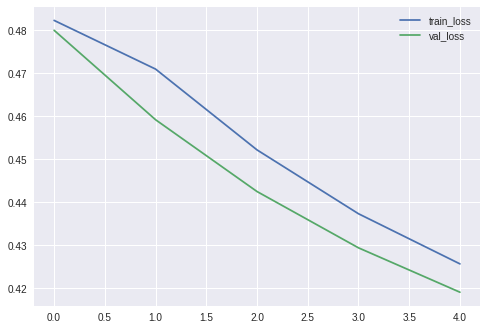

In [0]:
plt.plot(avg_loss,label='train_loss')
plt.plot(val_loss,label='val_loss')
plt.legend(loc='upper right')
plt.show()

In [0]:
img1 = sess.run(logits, feed_dict={x: val[:20]})

In [0]:
img1[img1<0] = 0

In [0]:
img1.min()

0.0

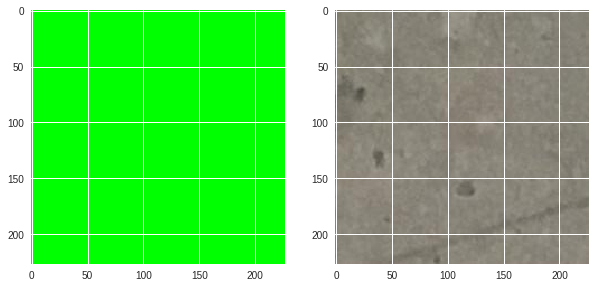

In [0]:
fig, ax = plt.subplots(1, 2,figsize=(10,10))
ax[0].imshow(img1[7])
ax[1].imshow(val[7])
plt.show()

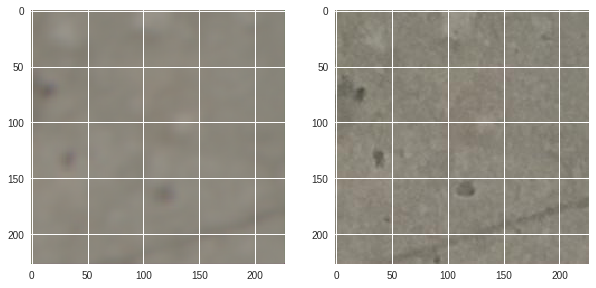

In [0]:
fig, ax = plt.subplots(1, 2,figsize=(10,10))
ax[0].imshow(img1[7])
ax[1].imshow(val[7])
plt.show()

In [0]:
test_filelist = glob.glob("drive/My Drive/positive1/*.*")

In [14]:
test_data = np.array([misc.imread(fname) for fname in test_filelist])
test_data.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


(2000, 227, 227, 3)

In [0]:
test_data= test_data/test_data.max()

In [0]:
img2 = sess.run(logits, feed_dict={x: test_data[:20]})

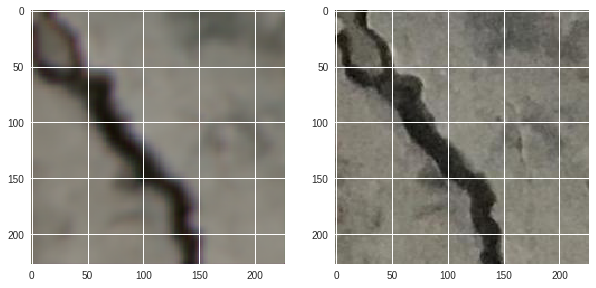

In [0]:
fig, ax = plt.subplots(1, 2,figsize=(10,10))
ax[0].imshow(img2[18])
ax[1].imshow(test_data[18])
plt.show()

In [0]:
i = test_data.copy()
i[i<0.5]=1
i[i<1]=0

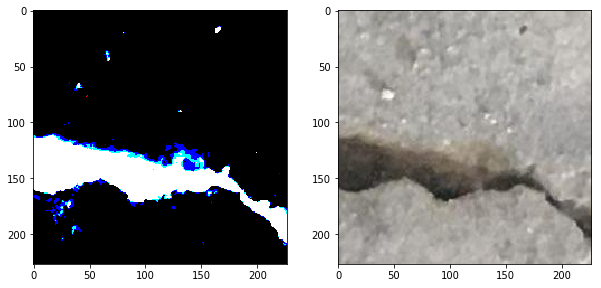

In [17]:
fig, ax = plt.subplots(1, 2,figsize=(10,10))
ax[0].imshow(i[500])
ax[1].imshow(test_data[500])
plt.show()

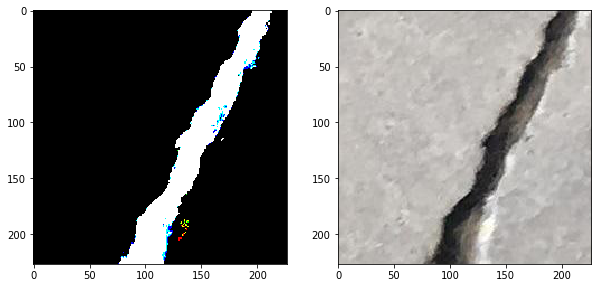

In [18]:
fig, ax = plt.subplots(1, 2,figsize=(10,10))
ax[0].imshow(i[2])
ax[1].imshow(test_data[2])
plt.show()

In [19]:
val_train = test_data[1600:]
val_train.shape

(400, 227, 227, 3)

In [0]:
t = test_data[:1600]

In [0]:
lable_train = i[:1600]
lable_val =  i[1600:]

In [22]:
val_train.shape,t.shape,lable_val.shape,lable_train.shape

((400, 227, 227, 3),
 (1600, 227, 227, 3),
 (400, 227, 227, 3),
 (1600, 227, 227, 3))

In [23]:
sess=tf.Session()
sess.run(tf.global_variables_initializer())


avg_loss =[]
val_loss =[]
for e_vals in range(epochs):
    cal_loss =[]
    vl_loss =[]
    for bat in range(int(len(t) / batch_size)):
        batch_data = t[bat * batch_size:bat * batch_size + batch_size]
        batch_fin = lable_train[bat * batch_size:bat * batch_size + batch_size]
        img,batch_cost, _ = sess.run([logits,cost, opt ], feed_dict={x: batch_data,y: batch_fin})
        cal_loss.append(batch_cost)
        print("\r {0}/{1}[{2}>{3}] {4}".format(bat+1,int(len(t) / batch_size),'=' * (bat+1),'.'*(int(len(t) / batch_size)-bat-1),batch_cost),end="")
    
    for val_bat in range(int(len(val_train) / batch_size)):
        batch_data = val_train[val_bat * batch_size:val_bat * batch_size + batch_size]
        batch_fin = lable_val[val_bat * batch_size:val_bat * batch_size + batch_size]
        img,val_cost = sess.run([logits,cost], feed_dict={x: batch_data,y: batch_fin})
        vl_loss.append(val_cost)
    
    tloss = np.array(cal_loss)
    tloss = tloss.mean()
    
    vloss = np.array(vl_loss)
    vloss = vloss.mean()
    
    avg_loss.append(tloss)
    val_loss.append(vloss)
    print("\n")
    print(('Epoch: {}/{}...').format(e_vals + 1, epochs), ('Training loss: {:.4f}').format(tloss),('Validation loss: {:.4f}').format(vloss))
    print("\n")

 80/80[================================================================================>] 0.18065743148326874

Epoch: 1/5... Training loss: 0.7059 Validation loss: 0.1943


 80/80[================================================================================>] 0.1520768254995346

Epoch: 2/5... Training loss: 0.1626 Validation loss: 0.1825


 80/80[================================================================================>] 0.12713778018951416

Epoch: 3/5... Training loss: 0.1397 Validation loss: 0.1251


 80/80[================================================================================>] 0.11761035770177841

Epoch: 4/5... Training loss: 0.1283 Validation loss: 0.1147


 80/80[================================================================================>] 0.10455901175737381

Epoch: 5/5... Training loss: 0.1208 Validation loss: 0.1096




In [0]:
avg_loss = np.array(avg_loss)
val_loss = np.array(val_loss)

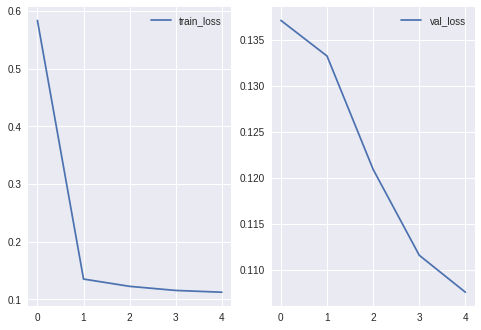

In [0]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(avg_loss,label='train_loss')
ax[1].plot(val_loss,label='val_loss')
ax[0].legend(loc='upper right')
ax[1].legend(loc='upper right')
plt.show()

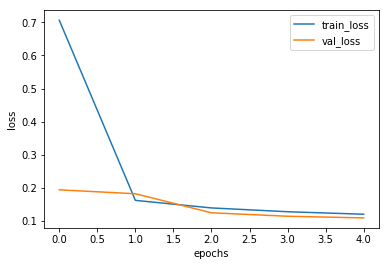

In [38]:
plt.plot(avg_loss,label='train_loss')
plt.plot(val_loss,label='val_loss')
plt.legend(loc='upper right')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

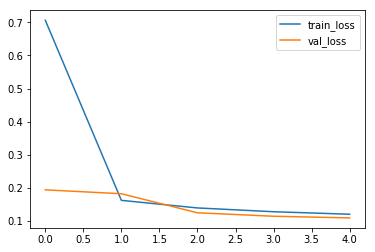

In [26]:
plt.plot(avg_loss,label='train_loss')
plt.plot(val_loss,label='val_loss')
plt.legend(loc='upper right')
plt.show()

In [0]:
img2 = sess.run(logits, feed_dict={x: val_train[:30]})

In [0]:
img2[img2<0]=0

In [0]:
img2.min()

0.0

In [0]:
img2[img2<0.2]=0
img2[img2>0.4]=1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


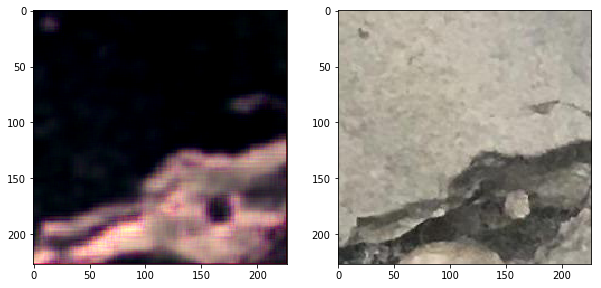

In [30]:
fig, ax = plt.subplots(1, 2,figsize=(10,10))
ax[0].imshow(img2[0])
ax[1].imshow(val_train[0])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


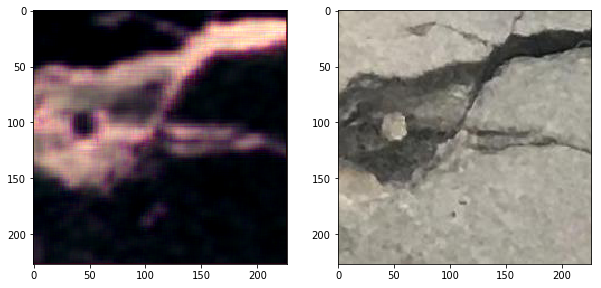

In [32]:
fig, ax = plt.subplots(1, 2,figsize=(10,10))
ax[0].imshow(img2[1])
ax[1].imshow(val_train[1])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


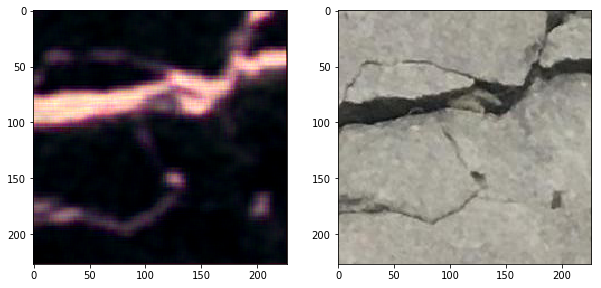

In [33]:
fig, ax = plt.subplots(1, 2,figsize=(10,10))
ax[0].imshow(img2[2])
ax[1].imshow(val_train[2])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


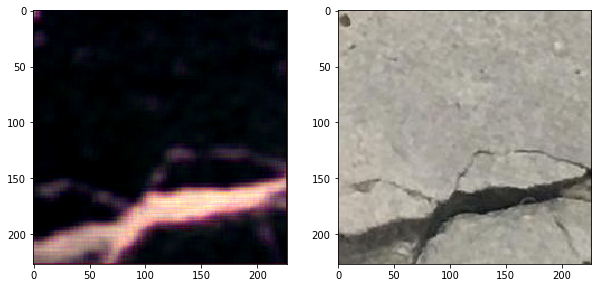

In [34]:
fig, ax = plt.subplots(1, 2,figsize=(10,10))
ax[0].imshow(img2[3])
ax[1].imshow(val_train[3])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


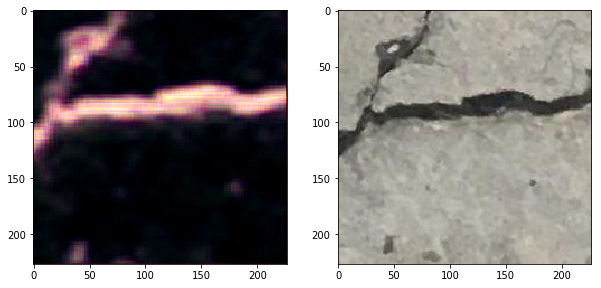

In [35]:
fig, ax = plt.subplots(1, 2,figsize=(10,10))
ax[0].imshow(img2[4])
ax[1].imshow(val_train[4])
plt.show()

## U - Net

In [0]:
tf.reset_default_graph()

In [0]:
x = tf.placeholder(tf.float32, [None, 227, 227, 3], name='input_data')
y = tf.placeholder(tf.float32, [None, 227, 227, 3], name='target_data')

In [0]:
epochs = 5
batch_size=10
l2_reg = 0.0001
#encoding-----
he_init = tf.contrib.layers.variance_scaling_initializer()
l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)

enc_conv0 = tf.layers.conv2d(x, 16, 3, activation=tf.nn.elu,kernel_initializer=he_init , kernel_regularizer=l2_regularizer)#225
enc_conv0 = tf.nn.dropout(enc_conv0,0.1)
#enc_conv0 = tf.layers.conv2d(enc_conv0, 16, 3, activation=tf.nn.elu,kernel_initializer=he_init , kernel_regularizer=l2_regularizer)#223
enc_conv0 = tf.nn.local_response_normalization(enc_conv0)
enc_max0 = tf.layers.max_pooling2d(enc_conv0, 2,1)

enc_conv1 = tf.layers.conv2d(enc_max0, 32, 3, activation=tf.nn.elu,kernel_initializer=he_init , kernel_regularizer=l2_regularizer)#220
enc_conv1 = tf.nn.dropout(enc_conv1,0.1)
#enc_conv1 = tf.layers.conv2d(enc_conv1, 32, 3, activation=tf.nn.elu,kernel_initializer=he_init , kernel_regularizer=l2_regularizer)#218
enc_conv1 = tf.nn.local_response_normalization(enc_conv1)
enc_max1 = tf.layers.max_pooling2d(enc_conv1, 2,1)

enc_conv2 = tf.layers.conv2d(enc_max1, 64, 3, activation=tf.nn.elu,kernel_initializer=he_init , kernel_regularizer=l2_regularizer)#215
enc_conv2 = tf.nn.dropout(enc_conv2,0.2)
#enc_conv2 = tf.layers.conv2d(enc_conv2, 64, 3, activation=tf.nn.elu,kernel_initializer=he_init , kernel_regularizer=l2_regularizer)#213
enc_conv2 = tf.nn.local_response_normalization(enc_conv2)
enc_max2 = tf.layers.max_pooling2d(enc_conv2, 2,1)

enc_conv3 = tf.layers.conv2d(enc_max2, 128, 3, activation=tf.nn.elu,kernel_initializer=he_init , kernel_regularizer=l2_regularizer)#210
enc_conv3 = tf.nn.dropout(enc_conv3,0.2)
#enc_conv3 = tf.layers.conv2d(enc_conv3, 128, 3, activation=tf.nn.elu,kernel_initializer=he_init , kernel_regularizer=l2_regularizer)#208
enc_conv3 = tf.nn.local_response_normalization(enc_conv3)
enc_max3 = tf.layers.max_pooling2d(enc_conv3, 2,1)


enc_conv4 = tf.layers.conv2d(enc_max3, 256, 3, activation=tf.nn.elu,kernel_initializer=he_init , kernel_regularizer=l2_regularizer)
enc_conv4 = tf.nn.dropout(enc_conv4,0.3)
#enc_conv4 = tf.layers.conv2d(enc_conv4, 256, 3, activation=tf.nn.elu,kernel_initializer=he_init , kernel_regularizer=l2_regularizer)

print(enc_conv0)
print(enc_conv1)
print(enc_conv2)
print(enc_conv3)
#decoding-----

dec_conv3 = tf.image.resize_nearest_neighbor(enc_conv4, tf.constant([216, 216]))
#dec_conv3 = tf.concat([dec_conv3,enc_conv3],3)
dec_conv3 = tf.layers.conv2d(dec_conv3, 128, 3, activation=tf.nn.elu,kernel_initializer=he_init , kernel_regularizer=l2_regularizer)
dec_conv3 = tf.nn.dropout(dec_conv3,0.2)
#dec_conv3 = tf.image.resize_nearest_neighbor(enc_conv4, tf.constant([210, 210]))
#dec_conv3 = tf.layers.conv2d(dec_conv3, 128, 3, activation=tf.nn.elu,kernel_initializer=he_init , kernel_regularizer=l2_regularizer)

dec_conv2 = tf.image.resize_nearest_neighbor(dec_conv3, tf.constant([219, 219]))
#dec_conv2 = tf.concat([dec_conv2,enc_conv2],3)
dec_conv2 = tf.layers.conv2d(dec_conv2, 64, 3, activation=tf.nn.elu,kernel_initializer=he_init , kernel_regularizer=l2_regularizer)
dec_conv2 = tf.nn.dropout(dec_conv2,0.2)
#dec_conv2 = tf.image.resize_nearest_neighbor(dec_conv3, tf.constant([215, 215]))
#dec_conv2 = tf.layers.conv2d(dec_conv2, 64, 3, activation=tf.nn.elu,kernel_initializer=he_init , kernel_regularizer=l2_regularizer)

dec_conv1 = tf.image.resize_nearest_neighbor(dec_conv2, tf.constant([222, 222]))
#dec_conv1 = tf.concat([dec_conv1,enc_conv1],3)
dec_conv1 = tf.layers.conv2d(dec_conv1, 32, 3, activation=tf.nn.elu,kernel_initializer=he_init , kernel_regularizer=l2_regularizer)
dec_conv1 = tf.nn.dropout(dec_conv1,0.1)
#dec_conv1 = tf.image.resize_nearest_neighbor(dec_conv2, tf.constant([220, 220]))
#dec_conv1 = tf.layers.conv2d(dec_conv1, 32, 3, activation=tf.nn.elu,kernel_initializer=he_init , kernel_regularizer=l2_regularizer)

dec_conv0 = tf.image.resize_nearest_neighbor(dec_conv1, tf.constant([225, 225]))
#dec_conv0 = tf.concat([dec_conv0,enc_conv0],3)
dec_conv0 = tf.layers.conv2d(dec_conv0, 16, 3, activation=tf.nn.elu,kernel_initializer=he_init , kernel_regularizer=l2_regularizer)
dec_conv0 = tf.nn.dropout(dec_conv0,0.1)
#dec_conv0 = tf.image.resize_nearest_neighbor(dec_conv1, tf.constant([225, 225]))
#dec_conv0 = tf.layers.conv2d(dec_conv0, 16, 3, activation=tf.nn.elu,kernel_initializer=he_init , kernel_regularizer=l2_regularizer)






dec_conv0 = tf.image.resize_nearest_neighbor(dec_conv0, tf.constant([227, 227]))
logits =    tf.layers.conv2d(dec_conv0, 3, (3, 3),padding='same',activation=None,name="logits")


reconstruction_loss = tf.reduce_mean(tf.square(y - logits))
reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)

cost = tf.add_n([reconstruction_loss] + reg_losses)

opt = tf.train.AdamOptimizer(0.001).minimize(cost)

Tensor("LRN:0", shape=(?, 225, 225, 16), dtype=float32)
Tensor("LRN_1:0", shape=(?, 222, 222, 32), dtype=float32)
Tensor("LRN_2:0", shape=(?, 219, 219, 64), dtype=float32)
Tensor("LRN_3:0", shape=(?, 216, 216, 128), dtype=float32)


In [0]:
epochs = 5
batch_size=10
l2_reg = 0.0001
#encoding-----
he_init = tf.contrib.layers.variance_scaling_initializer()
l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)

enc_conv0 = tf.layers.conv2d(x, 16, 3, activation=tf.nn.elu,kernel_initializer=he_init , kernel_regularizer=l2_regularizer,padding='SAME')
enc_conv0 = tf.nn.dropout(enc_conv0,0.1)
#enc_conv0 = tf.layers.conv2d(enc_conv0, 16, 3, activation=tf.nn.elu,kernel_initializer=he_init , kernel_regularizer=l2_regularizer,padding='SAME')
enc_conv0 = tf.nn.local_response_normalization(enc_conv0)
enc_max0 = tf.layers.max_pooling2d(enc_conv0, 2,1)

enc_conv1 = tf.layers.conv2d(enc_max0, 32, 3, activation=tf.nn.elu,kernel_initializer=he_init , kernel_regularizer=l2_regularizer,padding='SAME')
enc_conv1 = tf.nn.dropout(enc_conv1,0.1)
#enc_conv1 = tf.layers.conv2d(enc_conv1, 32, 3, activation=tf.nn.elu,kernel_initializer=he_init , kernel_regularizer=l2_regularizer,padding='SAME')
enc_conv1 = tf.nn.local_response_normalization(enc_conv1)
enc_max1 = tf.layers.max_pooling2d(enc_conv1, 2,1)

enc_conv2 = tf.layers.conv2d(enc_max1, 64, 3, activation=tf.nn.elu,kernel_initializer=he_init , kernel_regularizer=l2_regularizer,padding='SAME')
enc_conv2 = tf.nn.dropout(enc_conv2,0.2)
#enc_conv2 = tf.layers.conv2d(enc_conv2, 64, 3, activation=tf.nn.elu,kernel_initializer=he_init , kernel_regularizer=l2_regularizer,padding='SAME')
enc_conv2 = tf.nn.local_response_normalization(enc_conv2)
enc_max2 = tf.layers.max_pooling2d(enc_conv2, 2,1)

enc_conv3 = tf.layers.conv2d(enc_max2, 128, 3, activation=tf.nn.elu,kernel_initializer=he_init , kernel_regularizer=l2_regularizer,padding='SAME')
enc_conv3 = tf.nn.dropout(enc_conv3,0.2)
#enc_conv3 = tf.layers.conv2d(enc_conv3, 128, 3, activation=tf.nn.elu,kernel_initializer=he_init , kernel_regularizer=l2_regularizer,padding='SAME')
enc_conv3 = tf.nn.local_response_normalization(enc_conv3)
enc_max3 = tf.layers.max_pooling2d(enc_conv3, 2,1)


enc_conv4 = tf.layers.conv2d(enc_max3, 256, 3, activation=tf.nn.elu,kernel_initializer=he_init , kernel_regularizer=l2_regularizer,padding='SAME')
enc_conv4 = tf.nn.dropout(enc_conv4,0.3)
#enc_conv4 = tf.layers.conv2d(enc_conv4, 256, 3, activation=tf.nn.elu,kernel_initializer=he_init , kernel_regularizer=l2_regularizer,padding='SAME')

print(enc_conv0)
print(enc_conv1)
print(enc_conv2)
print(enc_conv3)
#decoding-----

dec_conv3 = tf.image.resize_nearest_neighbor(enc_conv4, tf.constant([224, 224]))
#dec_conv3 = tf.concat([dec_conv3,enc_conv3],3)
dec_conv3 = tf.layers.conv2d(dec_conv3, 128, 3, activation=tf.nn.elu,kernel_initializer=he_init , kernel_regularizer=l2_regularizer,padding='SAME')
dec_conv3 = tf.nn.dropout(dec_conv3,0.2)
#dec_conv3 = tf.layers.conv2d(dec_conv3, 128, 3, activation=tf.nn.elu,kernel_initializer=he_init , kernel_regularizer=l2_regularizer,padding='SAME')

dec_conv2 = tf.image.resize_nearest_neighbor(dec_conv3, tf.constant([225, 225]))
#dec_conv2 = tf.concat([dec_conv2,enc_conv2],3)
dec_conv2 = tf.layers.conv2d(dec_conv2, 64, 3, activation=tf.nn.elu,kernel_initializer=he_init , kernel_regularizer=l2_regularizer,padding='SAME')
dec_conv2 = tf.nn.dropout(dec_conv2,0.2)
#dec_conv2 = tf.layers.conv2d(dec_conv2, 64, 3, activation=tf.nn.elu,kernel_initializer=he_init , kernel_regularizer=l2_regularizer,padding='SAME')

dec_conv1 = tf.image.resize_nearest_neighbor(dec_conv2, tf.constant([226, 226]))
#dec_conv1 = tf.concat([dec_conv1,enc_conv1],3)
dec_conv1 = tf.layers.conv2d(dec_conv1, 32, 3, activation=tf.nn.elu,kernel_initializer=he_init , kernel_regularizer=l2_regularizer,padding='SAME')
dec_conv1 = tf.nn.dropout(dec_conv1,0.1)
#dec_conv1 = tf.layers.conv2d(dec_conv1, 32, 3, activation=tf.nn.elu,kernel_initializer=he_init , kernel_regularizer=l2_regularizer,padding='SAME')

dec_conv0 = tf.image.resize_nearest_neighbor(dec_conv1, tf.constant([227, 227]))
#dec_conv0 = tf.concat([dec_conv0,enc_conv0],3)
dec_conv0 = tf.layers.conv2d(dec_conv0, 16, 3, activation=tf.nn.elu,kernel_initializer=he_init , kernel_regularizer=l2_regularizer,padding='SAME')
dec_conv0 = tf.nn.dropout(dec_conv0,0.1)
#dec_conv0 = tf.layers.conv2d(dec_conv0, 16, 3, activation=tf.nn.elu,kernel_initializer=he_init , kernel_regularizer=l2_regularizer,padding='SAME')






#dec_conv0 = tf.image.resize_nearest_neighbor(enc_conv5, tf.constant([227, 227]))
logits =    tf.layers.conv2d(dec_conv0, 3, (3, 3),padding='same',activation=None,name="logits")


reconstruction_loss = tf.reduce_mean(tf.square(y - logits))
reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)

cost = tf.add_n([reconstruction_loss] + reg_losses)

opt = tf.train.AdamOptimizer(0.001).minimize(cost)

Tensor("LRN:0", shape=(?, 227, 227, 16), dtype=float32)
Tensor("LRN_1:0", shape=(?, 226, 226, 32), dtype=float32)
Tensor("LRN_2:0", shape=(?, 225, 225, 64), dtype=float32)
Tensor("LRN_3:0", shape=(?, 224, 224, 128), dtype=float32)


In [0]:
epochs = 5
batch_size=20
l2_reg = 0.0001
#encoding-----
l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
he_init = tf.contrib.layers.variance_scaling_initializer()

enc_conv0 = tf.layers.conv2d(x, 64, 3, activation=tf.nn.elu,kernel_initializer=he_init, kernel_regularizer=l2_regularizer) #223
#enc_max = tf.layers.max_pooling2d(enc_conv0, 3, 2) # 56
en_locl = tf.nn.local_response_normalization(enc_conv0)
enc_conv0 = tf.layers.conv2d(en_locl, 64, 3, activation=tf.nn.elu,kernel_initializer=he_init, kernel_regularizer=l2_regularizer)
enc_max1 = tf.layers.max_pooling2d(en_locl, 3, 2) #110

enc_conv1 = tf.layers.conv2d(enc_max1, 128, 3, activation=tf.nn.elu,kernel_initializer=he_init, kernel_regularizer=l2_regularizer) #108
enc_conv1 = tf.layers.conv2d(enc_conv1, 128, 3, activation=tf.nn.elu,kernel_initializer=he_init, kernel_regularizer=l2_regularizer) #108
enc_max2 = tf.layers.max_pooling2d(enc_conv1, 3, 2) #53

enc_conv2 = tf.layers.conv2d(enc_max2, 256, 3, activation=tf.nn.elu,kernel_initializer=he_init, kernel_regularizer=l2_regularizer) #108
enc_conv2 = tf.layers.conv2d(enc_conv2, 256, 3, activation=tf.nn.elu,kernel_initializer=he_init, kernel_regularizer=l2_regularizer) #108
enc_max2 = tf.layers.max_pooling2d(enc_conv2, 3, 2) #53

print(enc_conv0)
print(enc_conv1)
print(enc_conv2)

#decoding----

dec_conv2 = tf.image.resize_nearest_neighbor(enc_max2, tf.constant([108, 108]))
dec_conv2 = tf.layers.conv2d(dec_conv2, 128, 3, activation=tf.nn.elu,kernel_initializer=he_init, kernel_regularizer=l2_regularizer)
dec_conv2 = tf.layers.conv2d(dec_conv2, 128, 3, activation=tf.nn.elu,kernel_initializer=he_init, kernel_regularizer=l2_regularizer)

dec_conv1 = tf.image.resize_nearest_neighbor(dec_conv2, tf.constant([223, 223]))
dec_conv1 = tf.layers.conv2d(dec_conv1, 64, 3, activation=tf.nn.elu,kernel_initializer=he_init, kernel_regularizer=l2_regularizer)
dec_conv1 = tf.layers.conv2d(dec_conv1, 64, 3, activation=tf.nn.elu,kernel_initializer=he_init, kernel_regularizer=l2_regularizer)

dec_conv0 = tf.image.resize_nearest_neighbor(dec_conv1, tf.constant([227, 227]))
logits =    tf.layers.conv2d(dec_conv0, 3, (3, 3),padding='same',activation=None,kernel_initializer=he_init,kernel_regularizer=l2_regularizer,name="logits")


reconstruction_loss = tf.reduce_mean(tf.square(y - logits))
reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)

cost = tf.add_n([reconstruction_loss] + reg_losses)

opt = tf.train.AdamOptimizer(0.001).minimize(cost)

Tensor("conv2d_1/Elu:0", shape=(?, 223, 223, 64), dtype=float32)
Tensor("conv2d_3/Elu:0", shape=(?, 108, 108, 128), dtype=float32)
Tensor("conv2d_5/Elu:0", shape=(?, 49, 49, 256), dtype=float32)


In [0]:
sess=tf.Session()
sess.run(tf.global_variables_initializer())


avg_loss =[]
val_loss =[]
for e_vals in range(epochs):
    cal_loss =[]
    vl_loss =[]
    for bat in range(int(len(t) / batch_size)):
        batch_data = t[bat * batch_size:bat * batch_size + batch_size]
        batch_fin = lable_train[bat * batch_size:bat * batch_size + batch_size]
        img,batch_cost, _ = sess.run([logits,cost, opt ], feed_dict={x: batch_data,y: batch_fin})
        cal_loss.append(batch_cost)
        print("\r {0}/{1}[{2}>{3}] {4}".format(bat+1,int(len(t) / batch_size),'=' * (bat+1),'.'*(int(len(t) / batch_size)-bat-1),batch_cost),end="")
    
    for val_bat in range(int(len(val_train) / batch_size)):
        batch_data = val_train[val_bat * batch_size:val_bat * batch_size + batch_size]
        batch_fin = lable_val[val_bat * batch_size:val_bat * batch_size + batch_size]
        img,val_cost = sess.run([logits,cost], feed_dict={x: batch_data,y: batch_fin})
        vl_loss.append(val_cost)
    
    tloss = np.array(cal_loss)
    tloss = tloss.mean()
    
    vloss = np.array(vl_loss)
    vloss = vloss.mean()
    
    avg_loss.append(tloss)
    val_loss.append(vloss)
    print("\n")
    print(('Epoch: {}/{}...').format(e_vals + 1, epochs), ('Training loss: {:.4f}').format(tloss),('Validation loss: {:.4f}').format(vloss))
    print("\n")

 80/80[================================================================================>] 0.3424438238143921

Epoch: 1/5... Training loss: 6.9024 Validation loss: 0.3145


 80/80[================================================================================>] 0.37471288442611694

Epoch: 2/5... Training loss: 0.2966 Validation loss: 0.3860


 80/80[================================================================================>] 0.2910967469215393

Epoch: 3/5... Training loss: 0.2835 Validation loss: 0.2753


 80/80[================================================================================>] 0.26888903975486755

Epoch: 4/5... Training loss: 0.2720 Validation loss: 0.2604


 80/80[================================================================================>] 0.26619917154312134

Epoch: 5/5... Training loss: 0.2753 Validation loss: 0.2587




In [0]:
avg_loss = np.array(avg_loss)
val_loss = np.array(val_loss)

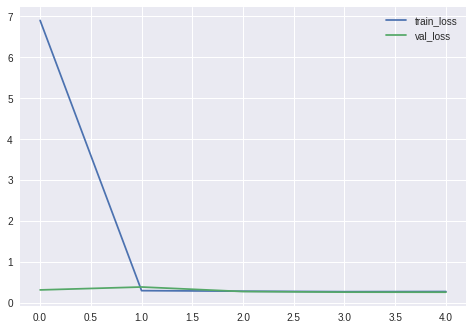

In [0]:
plt.plot(avg_loss,label='train_loss')
plt.plot(val_loss,label='val_loss')
plt.legend(loc='upper right')
plt.show()

In [0]:
img2 = sess.run(logits, feed_dict={x: val_train[:30]})

In [0]:
img2[img2<0]=0

In [0]:
img2.shape

(30, 227, 227, 1)

In [0]:
img2.min()

-0.5218901

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


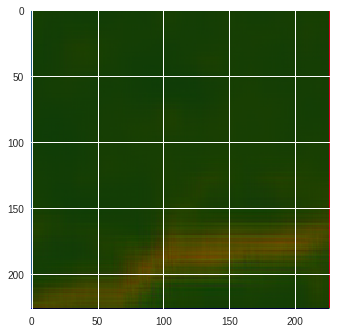

In [0]:
plt.imshow(img2[3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


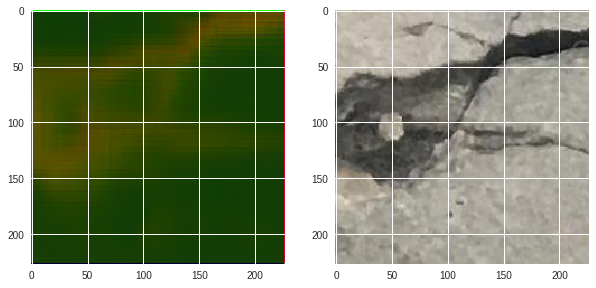

In [0]:
fig, ax = plt.subplots(1, 2,figsize=(10,10))
ax[0].imshow(img2[1])
ax[1].imshow(val_train[1])
plt.show()